In [419]:
import numpy as np
from fairlearn.datasets import fetch_acs_income
from sklearn import preprocessing
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import equalized_odds_difference
import numpy as np
# from privacy_meter.audit import Audit, MetricEnum
# from privacy_meter.dataset import Dataset
# from privacy_meter.information_source import InformationSource


import keras as keras
import tensorflow as tf
import matplotlib.pyplot as plt
# load dataset
import pandas as pd
from fairlearn.reductions import EqualizedOdds
import warnings
warnings.filterwarnings('ignore')

from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
# from privacy_meter.audit import Audit, MetricEnum
# from privacy_meter.dataset import Dataset
# from privacy_meter.information_source import InformationSource
# from privacy_meter.model import Fairlearn_Model, Sklearn_Model

In [420]:
from aif360.datasets import BinaryLabelDataset, StandardDataset
from data_utils import DatasetBuilder

# Load dataset

In [421]:
DATASET = "bank"
dataset_builder =  DatasetBuilder(DATASET)
dataset_orig = dataset_builder.load_data()

In [422]:
# Extract features (X) and labels (y) from the loaded dataset
X = dataset_orig.features
y_true = dataset_orig.labels.ravel()  # Flattening labels if needed

In [423]:
# Get sensitive attribute for analysis
sens_attr = dataset_orig.protected_attribute_names[0]  # 'age' is the protected attribute
sensitive_features = dataset_orig.features[:, dataset_orig.feature_names.index(sens_attr)]

In [424]:
# Normalize the features (similar to how it was done for `fetch_acs_income`)
X = preprocessing.normalize(X, norm='l2')

In [425]:
# Set up variables like they were in the original code
privileged_groups = dataset_builder.privileged_groups
unprivileged_groups = dataset_builder.unprivileged_groups

In [426]:
# Print the summary to verify data shapes and values
print(f"Features shape: {X.shape}")
print(f"Labels shape: {y_true.shape}")
print(f"Sensitive attribute: {sens_attr} with values {np.unique(sensitive_features)}")
print(f"Privileged groups: {privileged_groups}, Unprivileged groups: {unprivileged_groups}")

Features shape: (30488, 57)
Labels shape: (30488,)
Sensitive attribute: age with values [0. 1.]
Privileged groups: [{'age': 1}], Unprivileged groups: [{'age': 0}]


# Standard model

In [427]:
classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=10)
classifier.fit(X, y_true)

y_pred = classifier.predict(X)
gm = MetricFrame(metrics=accuracy_score, y_true=y_true, y_pred=y_pred, sensitive_features=sensitive_features)
print(gm.overall)
print(gm.by_group)
print(equalized_odds_difference(y_true,
                                y_pred,
                                sensitive_features=sensitive_features))

0.9218709000262398
sensitive_feature_0
0.0    0.862269
1.0    0.923609
Name: accuracy_score, dtype: float64
0.04326586378131433


# Fair models

In [428]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.metrics import equalized_odds_difference

np.random.seed(0)  # set seed for consistent results with ExponentiatedGradient
constraint = EqualizedOdds(difference_bound=0.0001)
classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X, y_true, sensitive_features=sensitive_features)
y_pred_mitigated = mitigator.predict(X)
sr_mitigated = MetricFrame(metrics=accuracy_score, y_true=y_true, y_pred=y_pred_mitigated, sensitive_features=sensitive_features)
print(sr_mitigated.overall)
print(sr_mitigated.by_group)

0.900583836263448
sensitive_feature_0
0.0    0.855324
1.0    0.901904
Name: accuracy_score, dtype: float64


In [429]:
print(equalized_odds_difference(y_true,
                                y_pred_mitigated,
                                sensitive_features=sensitive_features))

0.030595600955597657


# Attack models

In [430]:
# for the population metric
seed = 1234
np.random.seed(seed)
rng = np.random.default_rng(seed=seed) # useless

In [431]:
dataset_size = len(X)  # Should be 30,488

In [432]:
# Determine split sizes proportionally (to sum up to the full dataset size)
num_train_points = 15244  
num_test_points = 15244
# num_fair_train_points = 5000  # Reduced from 10000
# num_population_points = 10000  # Reduced from 30000

train_index = np.random.choice(X.shape[0], num_train_points, replace=False)
test_index = np.random.choice(X.shape[0], num_test_points, replace=False)
# fair_train_index = np.random.choice(X.shape[0], num_fair_train_points, replace=False)
population_index = train_index

In [380]:
# # Determine split sizes proportionally (to sum up to the full dataset size)
# num_train_points = 1500  # Reduced from 2000
# num_test_points = 1500   # Reduced from 2000
# num_fair_train_points = 5000  # Reduced from 10000
# num_population_points = 10000  # Reduced from 30000

# # Start with all indices
# all_indices = np.arange(X.shape[0])

# # Select train indices without replacement
# train_index = np.random.choice(all_indices, num_train_points, replace=False)
# # Remove train indices from available indices
# remaining_indices = np.setdiff1d(all_indices, train_index)

# # Select test indices from the remaining indices without replacement
# test_index = np.random.choice(remaining_indices, num_test_points, replace=False)
# # Remove test indices from available indices
# remaining_indices = np.setdiff1d(remaining_indices, test_index)

# # Select fair train indices from the remaining indices without replacement
# fair_train_index = np.random.choice(remaining_indices, num_fair_train_points, replace=False)
# # Remove fair train indices from available indices
# remaining_indices = np.setdiff1d(remaining_indices, fair_train_index)

# # Select population indices from the remaining indices (can also choose all remaining points)
# population_index = np.random.choice(remaining_indices, min(num_population_points, len(remaining_indices)), replace=False)

# # Summary of counts
# print(f"Number of train points: {len(train_index)}")
# print(f"Number of test points: {len(test_index)}")
# print(f"Number of fair train points: {len(fair_train_index)}")
# print(f"Number of population points: {len(population_index)}")

In [433]:
combined_indices = np.concatenate([train_index, test_index, population_index])
assert len(combined_indices) == len(np.unique(combined_indices)), "Overlapping indices detected!"

AssertionError: Overlapping indices detected!

In [434]:
input_shape= X.shape[-1]
num_classes= 1

In [435]:
unique_values, counts = np.unique(y_true, return_counts=True)
for value, count in zip(unique_values, counts):
    print(f"Number of {value}s: {count}")

Number of 0.0s: 26629
Number of 1.0s: 3859


In [436]:
unique_values, counts = np.unique(sensitive_features, return_counts=True)
for value, count in zip(unique_values, counts):
    print(f"Number of {value}s: {count}")

Number of 0.0s: 864
Number of 1.0s: 29624


In [437]:
result = (y_true[train_index])+ (sensitive_features[train_index] + 1) * 2
unique_values, counts = np.unique(result, return_counts=True)
for value, count in zip(unique_values, counts):
    print(f"Number of {value}s: {count}")

Number of 2.0s: 306
Number of 3.0s: 90
Number of 4.0s: 13000
Number of 5.0s: 1848


In [438]:
g_train = y_true[train_index] + (sensitive_features[train_index] + 1) * 2
g_test = y_true[test_index] + (sensitive_features[test_index] + 1) * 2
g_pop_train = y_true[population_index] + (sensitive_features[population_index] + 1) * 2

In [439]:
# Check lengths before creating datasets
assert len(train_index) == len(g_train), "Mismatch in train indices and group labels for train"
assert len(test_index) == len(g_test), "Mismatch in test indices and group labels for test"
assert len(population_index) == len(g_pop_train), "Mismatch in population indices and group labels for population"

In [440]:
# Check dimensions before using boolean indexing
print(f"g_train size: {g_train.shape}")
print(f"g_test size: {g_test.shape}")
print(f"g_test size: {g_pop_train.shape}")

g_train size: (15244,)
g_test size: (15244,)
g_test size: (15244,)


## from privacy_meter.dataset import Dataset

In [441]:
from itertools import product
from typing import Dict, Union

import numpy as np

########################################################################################################################
# DATASET CLASS
########################################################################################################################


class Dataset:
    """
    Wrapper around a dictionary-like formatted dataset, with functions to run preprocessing, to define default
    input/output features, and to split a dataset easily.
    """

    def __init__(
        self,
        data_dict: dict,
        default_input: str,
        default_output: str,
        default_group: str = None,
        preproc_fn_dict: dict = None,
        preprocessed: bool = False,
    ):
        """Constructor

        Args:
            data_dict: Contains the dataset as a dict.
            default_input: The key of the data_dict that should be used by default to get the input of a model.
            default_output: The key of the data_dict that should be used by default to get the expected output
                of a model.
            default_group: The key of the data_dict that shouuld be used by default to get the group of the data points.
                This is to contruct class dependent threshold.
            preproc_fn_dict: Contains optional preprocessing functions for each feature.
            preprocessed: Indicates if the preprocessing of preproc_fn_dict has already been applied.
        """

        # Store parameters
        self.data_dict = data_dict
        self.default_input = default_input
        self.default_output = default_output
        self.default_group = default_group
        self.preproc_fn_dict = preproc_fn_dict

        # Store splits names and features names
        self.splits = list(self.data_dict)
        self.features = list(self.data_dict[self.splits[0]])

        # If preprocessing functions were passed as parameters, execute them
        if not preprocessed and preproc_fn_dict is not None:
            self.preprocess()

    def preprocess(self):
        """
        Preprocessing function, executed by the constructor, based on the preproc_fn_dict attribute.
        """
        for (split, feature) in product(self.splits, self.features):
            if feature in list(self.preproc_fn_dict):
                fn = self.preproc_fn_dict[feature]
                self.data_dict[split][feature] = fn(self.data_dict[split][feature])

    def get_feature(self, split_name: str, feature_name: str, indices: list = None):
        """Returns a specific feature from samples of a specific split.

        Args:
            split_name: Name of the split.
            feature_name: Name of the feature.
            indices: Optional list of indices. If not specified, the entire subset is returned.

        Returns:
            The requested feature, from samples of the requested split.
        """

        # Two placeholders can be used to trigger either the default input or the default output, as specified during
        # object creation
        if feature_name == "<default_input>":
            feature_name = self.default_input
        elif feature_name == "<default_output>":
            feature_name = self.default_output
        elif feature_name == "<default_group>":
            feature_name = self.default_group

        # If 'indices' is not specified, returns the entire array. Else just return those indices
        if indices is None:
            return self.data_dict[split_name][feature_name]
        else:
            return self.data_dict[split_name][feature_name][indices]

    def subdivide(
        self,
        num_splits: int,
        split_names: list = None,
        method: str = "independent",
        split_size: Union[int, Dict[str, int]] = None,
        delete_original: bool = False,
        in_place: bool = True,
        return_results: bool = False,
    ):
        """Subdivides the splits contained in split_names into sub-splits, e.g. for shadow model training.

        Args:
            num_splits: Number of sub-splits per original split.
            split_names: The splits to subdivide (e.g. train and test). By default, includes all splits.
            method: Either independent or random. If method is independent, then the sub-splits are a partition of the
                original split (i.e. they contain the entire split without repetition). If method is random, then each
                sub-split is a random subset of the original split (i.e. some samples might be missing or repeated). If
                method is hybrid, then each sub-split is a random subset of the original split, with the guarantee that
                the 1st one is not overlapping with the others.
            split_size: If method is random, this is the size of one split (ignored if method is independent). Can
                either be an integer, or a dictionary of integer (one per split).
            delete_original: Indicates if the original split should be deleted.
            in_place: Indicates if the new splits should be included in the parent object or not
            return_results: Indicates if the new splits should be returned or not

        Returns:
            If in_place, a list of new Dataset objects, with the sub-splits. Otherwise, nothing, as the results are
            stored in self.data_dict.
        """

        # By default, includes all splits.
        if split_names is None:
            split_names = self.splits

        # List of results if in_place is False
        new_datasets_dict = [{} for _ in range(num_splits)]

        for split in split_names:

            if split_size is not None:
                parsed_split_size = (
                    split_size if isinstance(split_size, int) else split_size[split]
                )

            # If method is random, then each sub-split is a random subset of the original split.
            if method == "random":
                assert (
                    split_size is not None
                ), 'Argument split_size is required when method is "random" or "hybrid"'
                indices = np.random.randint(
                    self.data_dict[split][self.features[0]].shape[0],
                    size=(num_splits, parsed_split_size),
                )

            # If method is independent, then the sub-splits are a partition of the original split.
            elif method == "independent":
                indices = np.arange(self.data_dict[split][self.features[0]].shape[0])
                np.random.shuffle(indices)
                indices = np.array_split(indices, num_splits)

            # If method is hybrid, then each sub-split is a random subset of the original split, with the guarantee that
            # the 1st one is not overlapping with the others
            elif method == "hybrid":
                assert (
                    split_size is not None
                ), 'Argument split_size is required when method is "random" or "hybrid"'
                available_indices = np.arange(
                    self.data_dict[split][self.features[0]].shape[0]
                )
                indices_a = np.random.choice(
                    available_indices, size=(1, parsed_split_size), replace=False
                )
                available_indices = np.setdiff1d(available_indices, indices_a.flatten())
                indices_b = np.random.choice(
                    available_indices,
                    size=(num_splits - 1, parsed_split_size),
                    replace=True,
                )
                indices = np.concatenate((indices_a, indices_b))

            else:
                raise ValueError(f'Split method "{method}" does not exist.')

            for split_n in range(num_splits):
                # Fill the dictionary if in_place is True
                if in_place:
                    self.data_dict[f"{split}{split_n:03d}"] = {}
                    for feature in self.features:
                        self.data_dict[f"{split}{split_n:03d}"][
                            feature
                        ] = self.data_dict[split][feature][indices[split_n]]
                # Create new dictionaries if return_results is True
                if return_results:
                    new_datasets_dict[split_n][f"{split}"] = {}
                    for feature in self.features:
                        new_datasets_dict[split_n][f"{split}"][
                            feature
                        ] = self.data_dict[split][feature][indices[split_n]]

            # delete_original indicates if the original split should be deleted.
            if delete_original:
                del self.data_dict[split]

        # Update the list of splits
        self.splits = list(self.data_dict)

        # Return new datasets if return_results is True
        if return_results:
            return [
                Dataset(
                    data_dict=new_datasets_dict[i],
                    default_input=self.default_input,
                    default_output=self.default_output,
                    default_group=self.default_group,
                    preproc_fn_dict=self.preproc_fn_dict,
                    preprocessed=True,
                )
                for i in range(num_splits)
            ]

    def __str__(self):
        """
        Returns a string describing the dataset.
        """
        txt = [
            f'{" DATASET OBJECT ":=^48}',
            f"Splits            = {self.splits}",
            f"Features          = {self.features}",
            f"Default features  = {self.default_input} --> {self.default_output}",
            "=" * 48,
        ]
        return "\n".join(txt)

In [442]:
# create the target model's dataset
train_ds = {'x': X[train_index], 'y': y_true[train_index],'g':g_train}
test_ds = {'x': X[test_index], 'y': y_true[test_index], 'g':g_test}
target_dataset = Dataset(
    data_dict={'train': train_ds, 'test': test_ds},
    default_input='x', default_output='y', default_group='g'
)

# create the reference dataset
population_ds = {'x': X[population_index], 'y': y_true[population_index], 'g': g_pop_train}
reference_dataset = Dataset(
    data_dict={'train': population_ds},
    default_input='x', default_output='y', default_group='g'
)

## from privacy_meter.model import Fairlearn_Model, Sklearn_Model

In [443]:
from abc import ABC, abstractmethod
from copy import deepcopy

import numpy as np
import tensorflow as tf
import torch
from opacus import GradSampleModule  # For speeding up the gradient computation
from scipy.special import softmax

########################################################################################################################
# MODEL CLASS
########################################################################################################################


class Model(ABC):
    """
    Interface to query a model without any assumption on how it is implemented.
    """

    def __init__(self, model_obj, loss_fn):
        """Constructor

        Args:
            model_obj: Model object.
            loss_fn: Loss function.
        """
        self.model_obj = model_obj
        self.loss_fn = loss_fn

    @abstractmethod
    def get_logits(self, batch_samples):
        """Function to get the model output from a given input.

        Args:
            batch_samples: Model input.

        Returns:
            Model output
        """
        pass

    @abstractmethod
    def get_loss(self, batch_samples, batch_labels, per_point=True):
        """Function to get the model loss on a given input and an expected output.

        Args:
            batch_samples: Model input.
            batch_labels: Model expected output.
            per_point: Boolean indicating if loss should be returned per point or reduced.

        Returns:
            The loss value, as defined by the loss_fn attribute.
        """
        pass

    @abstractmethod
    def get_grad(self, batch_samples, batch_labels):
        """Function to get the gradient of the model loss with respect to the model parameters, on a given input and an
        expected output.

        Args:
            batch_samples: Model input.
            batch_labels: Model expected output.

        Returns:
            A list of gradients of the model loss (one item per layer) with respect to the model parameters.
        """
        pass

    @abstractmethod
    def get_intermediate_outputs(self, layers, batch_samples, forward_pass=True):
        """Function to get the intermediate output of layers (a.k.a. features), on a given input.

        Args:
            layers: List of integers and/or strings, indicating which layers values should be returned.
            batch_samples: Model input.
            forward_pass: Boolean indicating if a new forward pass should be executed. If True, then a forward pass is
                executed on batch_samples. Else, the result is the one of the last forward pass.

        Returns:
            A list of intermediate outputs of layers.
        """
        pass

In [444]:
class Sklearn_Model(Model):
    """Inherits from the Model class, an interface to query a model without any assumption on how it is implemented.
    This particular class is to be used with tensorflow models.
    """

    def __init__(self, model_obj, loss_fn):
        """Constructor

        Args:
            model_obj: Model object.
            loss_fn: Loss function.
        """

        # Imports tensorflow with global scope
        globals()["tf"] = __import__("tensorflow")

        # Initializes the parent model
        super().__init__(model_obj, loss_fn)

    def get_logits(self, batch_samples):
        """Function to get the model output from a given input.

        Args:
            batch_samples: Model input.

        Returns:
            Model output.
        """
        return self.model_obj.predict_proba(batch_samples)[:, -1]

    def get_loss(self, batch_samples, batch_labels, per_point=True):
        """Function to get the model loss on a given input and an expected output.

        Args:
            batch_samples: Model input.
            batch_labels: Model expected output.
            per_point: Boolean indicating if loss should be returned per point or reduced.

        Returns:
            The loss value, as defined by the loss_fn attribute.
        """
        return self.loss_fn(batch_labels, self.get_logits(batch_samples))

    def get_grad(self, batch_samples, batch_labels):
        return None

    def get_intermediate_outputs(self, layers, batch_samples, forward_pass=True):
        return None

    def __tf_list_to_np_list(self, x):
        if isinstance(x, list):
            return [self.__tf_list_to_np_list(y) for y in x]
        else:
            return x.numpy()

In [445]:
class Fairlearn_Model(Model):
    """Inherits from the Model class, an interface to query a model without any assumption on how it is implemented.
    This particular class is to be used with tensorflow models.
    """

    def __init__(self, model_obj, loss_fn):
        """Constructor

        Args:
            model_obj: Model object.
            loss_fn: Loss function.
        """

        # Imports tensorflow with global scope
        globals()["tf"] = __import__("tensorflow")

        # Initializes the parent model
        super().__init__(model_obj, loss_fn)

    def get_logits(self, batch_samples):
        """Function to get the model output from a given input.

        Args:
            batch_samples: Model input.

        Returns:
            Model output.
        """
        logits = []
        for i in range(len(self.model_obj.predictors_)):
            logits.append(
                self.model_obj.weights_[i]
                * self.model_obj.predictors_[i].predict_proba(batch_samples)[:, -1]
            )

        return np.mean(logits, axis=0)

    def get_loss(self, batch_samples, batch_labels, per_point=True):
        """Function to get the model loss on a given input and an expected output.

        Args:
            batch_samples: Model input.
            batch_labels: Model expected output.
            per_point: Boolean indicating if loss should be returned per point or reduced.

        Returns:
            The loss value, as defined by the loss_fn attribute.
        """
        loss = []
        for i in range(len(self.model_obj.predictors_)):
            loss.append(
                self.model_obj.weights_[i]
                * self.loss_fn(
                    batch_labels,
                    self.model_obj.predictors_[i].predict_proba(batch_samples)[:, -1],
                )
            )

        return np.mean(loss, axis=0)

        # return self.loss_fn(batch_labels, self.get_logits(batch_samples))

    def get_grad(self, batch_samples, batch_labels):
        return None

    def get_intermediate_outputs(self, layers, batch_samples, forward_pass=True):
        return None

    def __tf_list_to_np_list(self, x):
        if isinstance(x, list):
            return [self.__tf_list_to_np_list(y) for y in x]
        else:
            return x.numpy()

In [446]:
def log(y, pre):
    e = 0.0000001
    pre = np.clip(pre, e, 1 - e)
    return - y * np.log(pre) - (1 - y) * np.log(1 - pre)

model = DecisionTreeClassifier(min_samples_leaf=10, max_depth=8)
model.fit(X[train_index], y_true[train_index])
target_model = Sklearn_Model(model_obj=model, loss_fn=log)
print(model)
y_pred_test= model.predict(X[test_index])
sr_test = MetricFrame(metrics=accuracy_score, y_true=y_true[test_index], y_pred=y_pred_test, sensitive_features=sensitive_features[test_index])
y_pred_train= model.predict(X[train_index])
sr_train = MetricFrame(metrics=accuracy_score, y_true=y_true[train_index], y_pred=y_pred_train, sensitive_features=sensitive_features[train_index])
print(sr_test.overall, sr_test.by_group)
print(sr_train.overall, sr_train.by_group)
print(equalized_odds_difference(y_true[test_index],y_pred_test, sensitive_features=sensitive_features[test_index]))

DecisionTreeClassifier(max_depth=8, min_samples_leaf=10)
0.9087509839937025 sensitive_feature_0
0.0    0.836449
1.0    0.910840
Name: accuracy_score, dtype: float64
0.9211493046444503 sensitive_feature_0
0.0    0.858586
1.0    0.922818
Name: accuracy_score, dtype: float64
0.035475852347121736


In [447]:
constraint = EqualizedOdds(difference_bound=0.0001)
classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=8)
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X[train_index], y_true[train_index], sensitive_features=sensitive_features[train_index])
fair_target_model = Fairlearn_Model(model_obj=mitigator, loss_fn=log)
print(mitigator)
y_pred_test= mitigator.predict(X[test_index])
sr_test = MetricFrame(metrics=accuracy_score, y_true=y_true[test_index], y_pred=y_pred_test, sensitive_features=sensitive_features[test_index])
y_pred_train= mitigator.predict(X[train_index])
sr_train = MetricFrame(metrics=accuracy_score, y_true=y_true[train_index], y_pred=y_pred_train, sensitive_features=sensitive_features[train_index])
print(sr_test.overall, sr_test.by_group)
print(sr_train.overall, sr_train.by_group)
print(equalized_odds_difference(y_true[test_index],y_pred_test, sensitive_features=sensitive_features[test_index]))

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.EqualizedOdds object at 0x0000020CA8006850>,
                      estimator=DecisionTreeClassifier(max_depth=8,
                                                       min_samples_leaf=10),
                      nu=0.001091446764068881)
0.9078981894515875 sensitive_feature_0
0.0    0.836449
1.0    0.909962
Name: accuracy_score, dtype: float64
0.9212805038047757 sensitive_feature_0
0.0    0.893939
1.0    0.922010
Name: accuracy_score, dtype: float64
0.06738350852185038


## from privacy_meter.information_source_signal import Signal, GroupInfo

In [448]:
class Signal(ABC):
    """
    Abstract class, representing any type of signal that can be obtained from a Model and/or a Dataset.
    """

    @abstractmethod
    def __call__(
        self,
        models: List[Model],
        datasets: List[Dataset],
        model_to_split_mapping: List[Tuple[int, str, str, str]],
        extra: dict,
    ):
        """Built-in call method.

        Args:
            models: List of models that can be queried.
            datasets: List of datasets that can be queried.
            model_to_split_mapping: List of tuples, indicating how each model should query the dataset.
                More specifically, for model #i:
                model_to_split_mapping[i][0] contains the index of the dataset in the list,
                model_to_split_mapping[i][1] contains the name of the split,
                model_to_split_mapping[i][2] contains the name of the input feature,
                model_to_split_mapping[i][3] contains the name of the output feature.
                This can also be provided once and for all at the instantiation of InformationSource, through the
                default_model_to_split_mapping argument.
            extra: Dictionary containing any additional parameter that should be passed to the signal object.

        Returns:
            The signal value.
        """
        pass

In [449]:
########################################################################################################################
# Group Information
########################################################################################################################


class GroupInfo(Signal):
    """
    Inherits from the Signal class, used to represent any type of signal that can be obtained from a Model and/or a
    Dataset.
    This particular class is used to get the group membership of data records.
    """

    def __call__(
        self,
        models: List[Model],
        datasets: List[Dataset],
        model_to_split_mapping: List[Tuple[int, str, str, str]],
        extra: dict,
    ):
        """Built-in call method.

        Args:
            models: List of models that can be queried.
            datasets: List of datasets that can be queried.
            model_to_split_mapping: List of tuples, indicating how each model should query the dataset.
                More specifically, for model #i:
                model_to_split_mapping[i][0] contains the index of the dataset in the list,
                model_to_split_mapping[i][1] contains the name of the split,
                model_to_split_mapping[i][2] contains the name of the group feature
                This can also be provided once and for all at the instantiation of InformationSource, through the
                default_model_to_split_mapping argument.
            extra: Dictionary containing any additional parameter that should be passed to the signal object.

        Returns:
            The signal value.
        """

        results = []
        # Given the group membership for each dataset used by each model
        for k in range(len(models)):
            dataset_index, split_name, group_feature = model_to_split_mapping[k]
            g = datasets[dataset_index].get_feature(split_name, group_feature)
            results.append(g)
        return results


class ModelGradientNorm(Signal):
    """
    Inherits from the Signal class, used to represent any type of signal that can be obtained from a Model and/or a
    Dataset.
    This particular class is used to get the gradient norm of a model.
    """

    def __call__(
        self,
        models: List[Model],
        datasets: List[Dataset],
        model_to_split_mapping: List[Tuple[int, str, str, str]],
        extra: dict,
    ):
        """Built-in call method.

        Args:
            models: List of models that can be queried.
            datasets: List of datasets that can be queried.
            model_to_split_mapping: List of tuples, indicating how each model should query the dataset.
                More specifically, for model #i:
                model_to_split_mapping[i][0] contains the index of the dataset in the list,
                model_to_split_mapping[i][1] contains the name of the split,
                model_to_split_mapping[i][2] contains the name of the input feature,
                model_to_split_mapping[i][3] contains the name of the output feature.
                This can also be provided once and for all at the instantiation of InformationSource, through the
                default_model_to_split_mapping argument.
            extra: Dictionary containing any additional parameter that should be passed to the signal object.

        Returns:
            The signal value.
        """

        results = []
        # Compute the signal for each model
        for k, model in enumerate(models):
            # Extract the features to be used
            (
                dataset_index,
                split_name,
                input_feature,
                output_feature,
            ) = model_to_split_mapping[k]
            x = datasets[dataset_index].get_feature(split_name, input_feature)
            y = datasets[dataset_index].get_feature(split_name, output_feature)
            results.append(model.get_gradnorm(x, y))
        return results

In [450]:
########################################################################################################################
# MODEL_LOSS CLASS
########################################################################################################################


class ModelLoss(Signal):
    """
    Inherits from the Signal class, used to represent any type of signal that can be obtained from a Model and/or a
    Dataset.
    This particular class is used to get the loss of a model.
    """

    def __call__(
        self,
        models: List[Model],
        datasets: List[Dataset],
        model_to_split_mapping: List[Tuple[int, str, str, str]],
        extra: dict,
    ):
        """Built-in call method.

        Args:
            models: List of models that can be queried.
            datasets: List of datasets that can be queried.
            model_to_split_mapping: List of tuples, indicating how each model should query the dataset.
                More specifically, for model #i:
                model_to_split_mapping[i][0] contains the index of the dataset in the list,
                model_to_split_mapping[i][1] contains the name of the split,
                model_to_split_mapping[i][2] contains the name of the input feature,
                model_to_split_mapping[i][3] contains the name of the output feature.
                This can also be provided once and for all at the instantiation of InformationSource, through the
                default_model_to_split_mapping argument.
            extra: Dictionary containing any additional parameter that should be passed to the signal object.

        Returns:
            The signal value.
        """

        results = []
        # Compute the signal for each model
        for k, model in enumerate(models):
            # Extract the features to be used
            (
                dataset_index,
                split_name,
                input_feature,
                output_feature,
            ) = model_to_split_mapping[k]
            x = datasets[dataset_index].get_feature(split_name, input_feature)

            # Check if output feature has been provided, else pass None
            if output_feature is not None:
                y = datasets[dataset_index].get_feature(split_name, output_feature)
            else:
                y = None

            # Compute the signal for each sample
            results.append(model.get_loss(x, y))
        return results

## from privacy_meter.information_source import InformationSource

In [451]:
########################################################################################################################
# INFORMATION_SOURCE CLASS
########################################################################################################################


class InformationSource:
    """
    Interface to dispatch Model objects, Dataset objects, and any additional objects required, to Signal objects.
    """

    def __init__(
        self,
        models: List[Model],
        datasets: List[Dataset],
        default_model_to_split_mapping: List[Tuple[int, str, str, str]] = None,
    ):
        """Constructor

        Args:
            models: List of models to be queried.
            datasets: List of datasets to be queried.
            default_model_to_split_mapping: List of tuples, indicating how each model should query the dataset.
                More specifically, for model #i:
                default_model_to_split_mapping[i][0] contains the index of the dataset in the list,
                default_model_to_split_mapping[i][1] contains the name of the split,
                default_model_to_split_mapping[i][2] contains the name of the input feature,
                default_model_to_split_mapping[i][3] contains the name of the output feature.
                This can also be provided independently for each call, through the model_to_split_mapping argument of
                the get_signal function.
        """
        self.models = models
        self.datasets = datasets
        self.default_model_to_split_mapping = default_model_to_split_mapping

    def get_signal(
        self,
        signal: Signal,
        model_to_split_mapping: List[Tuple[int, str, str, str]] = None,
        extra: dict = None,
    ):
        """Calls the signal object with the appropriate arguments: Model objects and Dataset objects specified at
        object instantiation, plus and any additional object required.

        Args:
            signal: The signal object to call.
            model_to_split_mapping: List of tuples, indicating how each model should query the dataset.
                More specifically, for model #i:
                model_to_split_mapping[i][0] contains the index of the dataset in the list,
                model_to_split_mapping[i][1] contains the name of the split,
                model_to_split_mapping[i][2] contains the name of the input feature,
                model_to_split_mapping[i][3] contains the name of the output feature.
                This can also be provided once and for all at the instantiation of InformationSource, through the
                default_model_to_split_mapping argument.
            extra: Dictionary containing any additional parameter that should be passed to the signal object.

        Returns:
            The signal value.
        """
        
        print("MODEL_TO_SPLIT_MAPPING in get_signal: ", model_to_split_mapping)        
        print("DEFAULT_MODEL_TO_SPLIT_MAPPING in get_signal: ", self.default_model_to_split_mapping)

        # If no value of model_to_split_mapping is provided, use the default value
        if model_to_split_mapping is None:
            print("MODEL_TO_SPLIT_MAPPING IS NONE")        
            model_to_split_mapping = self.default_model_to_split_mapping
        
        print("MODEL_TO_SPLIT_MAPPING in get_signal AFTER DEFAULT: ", model_to_split_mapping)

        # If no value of model_to_split_mapping is provided and no default value is set, raise an exception
        if model_to_split_mapping is None:
            raise TypeError(
                "At least one of self.default_model_to_split_mapping and model_to_split_mapping should be specified"
            )

        # Calls the signal object, and returns the value of the call
        return signal(
            models=self.models,
            datasets=self.datasets,
            model_to_split_mapping=model_to_split_mapping,
            extra=extra,
        )

In [452]:
un_target_info_source = InformationSource(
    models=[target_model],
    datasets=[target_dataset]
)

un_reference_info_source = InformationSource(
    models=[target_model],
    datasets=[reference_dataset]
)

fair_target_info_source = InformationSource(
    models=[fair_target_model],
    datasets=[target_dataset]
)

fair_reference_info_source = InformationSource(
    models=[fair_target_model],
    datasets=[reference_dataset]
)

## from privacy_meter.constants import InferenceGame, MetricEnum, NPZ_EXTENSION, SignalSourceEnum


In [453]:
from enum import Enum

########################################################################################################################
# ENUM: TYPES OF METRICS
########################################################################################################################


class MetricEnum(Enum):
    POPULATION = "population_metric"
    SHADOW = "shadow_metric"
    REFERENCE = "reference_metric"
    GROUPPOPULATION = "group_population_metric"

In [454]:
########################################################################################################################
# ENUM: TYPE OF INFERENCE GAME
########################################################################################################################


class InferenceGame(Enum):
    AVG_PRIVACY_LOSS_TRAINING_ALGO = "Average privacy loss of a training algorithm"
    PRIVACY_LOSS_MODEL = "Privacy loss of a model"
    PRIVACY_LOSS_SAMPLE = "Privacy loss of a data record"
    WORST_CASE_PRIVACY_LOSS_TRAINING_ALGO = (
        "Worst-case privacy loss of a training algorithm"
    )

In [455]:
NPZ_EXTENSION = ".npz"

In [456]:
########################################################################################################################
# ENUM: SOURCES FOR COMPUTING SIGNALS
########################################################################################################################


class SignalSourceEnum(Enum):
    TARGET_MEMBER = "target_member"
    TARGET_NON_MEMBER = "target_non_member"
    REFERENCE = "reference"
    REFERENCE_MEMBER = "reference_member"
    REFERENCE_NON_MEMBER = "reference_non_member"

## from privacy_meter.hypothesis_test import linear_itp_threshold_func

In [457]:
########################################################################################################################
# HYPOTHESIS TEST: LINEAR INTERPOLATION THRESHOLDING
########################################################################################################################


def linear_itp_threshold_func(
    distribution: List[float],
    alpha: List[float],
    **kwargs,
) -> float:
    """
    Function that returns the threshold as the alpha quantile of
    a linear interpolation curve fit over the provided distribution.
    Args:
        distribution: Sequence of values that form the distribution from which
        the threshold is computed. (Here we only consider positive signal values.)
        alpha: Quantile value that will be used to obtain the threshold from the
            distribution.
    Returns:
        threshold: alpha quantile of the provided distribution.
    """

    if len(distribution.shape) > 1:
        # for reference attacks
        threshold = np.quantile(
            distribution, q=alpha[1:-1], method="linear", axis=1, **kwargs
        )
        threshold = np.concatenate(
            [
                threshold,
                np.repeat(distribution.max() + 1e-4, distribution.shape[0]).reshape(
                    1, -1
                ),
            ],
            axis=0,
        )
        threshold = np.concatenate(
            [
                np.repeat(distribution.min() - 1e-4, distribution.shape[0]).reshape(
                    1, -1
                ),
                threshold,
            ],
            axis=0,
        )

    else:
        threshold = np.quantile(distribution, q=alpha[1:-1], method="linear", **kwargs)
        threshold = np.concatenate(
            [
                np.array(distribution.min() - 1e-4).reshape(-1),
                threshold,
                np.array(distribution.max() + 1e-4).reshape(-1),
            ],
            axis=0,
        )

    return threshold

## from privacy_meter.metric_result import CombinedMetricResult, MetricResult

In [458]:
from typing import List

import numpy as np
from sklearn.metrics import (
    accuracy_score,
    auc,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)

########################################################################################################################
# METRIC_RESULT CLASS
########################################################################################################################


class MetricResult:
    """
    Contains results related to the performance of the metric.
    """

    def __init__(
        self,
        metric_id: str,
        predicted_labels: list,
        true_labels: list,
        predictions_proba: List[List[float]] = None,
        signal_values=None,
        threshold: float = None,
    ):
        """
        Constructor.
        Computes and stores the accuracy, ROC AUC score, and the confusion matrix for a metric.

        Args:
            metric_id: ID of the metric that was used (c.f. the report_files/explanations.json file).
            predicted_labels: Membership predictions of the metric.
            true_labels: True membership labels used to evaluate the metric.
            predictions_proba: Continuous version of the predicted_labels.
            signal_values: Values of the signal used by the metric.
            threshold: Threshold computed by the metric.
        """
        self.metric_id = metric_id
        self.predicted_labels = predicted_labels
        self.true_labels = true_labels
        self.predictions_proba = predictions_proba
        self.signal_values = signal_values
        self.threshold = threshold

        self.accuracy = accuracy_score(y_true=true_labels, y_pred=predicted_labels)

        if self.predictions_proba is None:
            self.roc = roc_curve(y_true=true_labels, y_score=predicted_labels)
        else:
            self.roc = roc_curve(y_true=true_labels, y_score=predictions_proba)

        if self.predictions_proba is None:
            self.roc_auc = roc_auc_score(y_true=true_labels, y_score=predicted_labels)
        else:
            self.roc_auc = roc_auc_score(y_true=true_labels, y_score=predictions_proba)

        self.tn, self.fp, self.fn, self.tp = confusion_matrix(
            y_true=true_labels, y_pred=predicted_labels
        ).ravel()

    def __str__(self):
        """
        Returns a string describing the metric result.
        """
        txt = [
            f'{" METRIC RESULT OBJECT ":=^48}',
            f"Accuracy          = {self.accuracy}",
            f"ROC AUC Score     = {self.roc_auc}",
            f"FPR               = {self.fp / (self.fp + self.tn)}",
            f"TN, FP, FN, TP    = {self.tn, self.fp, self.fn, self.tp}",
        ]
        return "\n".join(txt)

In [459]:
class CombinedMetricResult:
    """
    Contains results related to the performance of the metric. It contains the results for multiple fpr.
    """

    def __init__(
        self,
        metric_id: str,
        predicted_labels: list,
        true_labels: list,
        predictions_proba=None,
        signal_values=None,
        threshold: float = None,
    ):
        """
        Constructor.
        Computes and stores the accuracy, ROC AUC score, and the confusion matrix for a metric.

        Args:
            metric_id: ID of the metric that was used (c.f. the report_files/explanations.json file).
            predicted_labels: Membership predictions of the metric.
            true_labels: True membership labels used to evaluate the metric.
            predictions_proba: Continuous version of the predicted_labels.
            signal_values: Values of the signal used by the metric.
            threshold: Threshold computed by the metric.
        """
        self.metric_id = metric_id
        self.predicted_labels = predicted_labels
        self.true_labels = true_labels
        self.predictions_proba = predictions_proba
        self.signal_values = signal_values
        self.threshold = threshold

        self.accuracy = np.mean(predicted_labels == true_labels, axis=1)
        self.tn = np.sum(true_labels == 0) - np.sum(
            predicted_labels[:, true_labels == 0], axis=1
        )
        self.tp = np.sum(predicted_labels[:, true_labels == 1], axis=1)
        self.fp = np.sum(predicted_labels[:, true_labels == 0], axis=1)
        self.fn = np.sum(true_labels == 1) - np.sum(
            predicted_labels[:, true_labels == 1], axis=1
        )

        self.roc_auc = auc(
            self.fp / (np.sum(true_labels == 0)), self.tp / (np.sum(true_labels == 1))
        )

    def __str__(self):
        """
        Returns a string describing the metric result.
        """
        txt_list = []
        for idx in range(len(self.accuracy)):
            txt = [
                f'{" METRIC RESULT OBJECT ":=^48}',
                f"Accuracy          = {self.accuracy[idx]}",
                f"ROC AUC Score     = {self.roc_auc}",
                f"FPR               = {self.fp[idx] / (self.fp[idx] + self.tn[idx])}",
                f"TN, FP, FN, TP    = {self.tn[idx], self.fp[idx], self.fn[idx], self.tp[idx]}",
            ]

            txt_list.append("\n".join(txt))
        return "\n\n".join(txt_list)

## from privacy_meter.utils import default_quantile, flatten_array

In [460]:
import numpy as np


def flatten_array(arr):
    """
    Utility function to recursively flatten a list of lists.
    Each element in the list can be another list, tuple, set, or np.ndarray,
    and can have variable sizes.

    Args:
        arr: List of lists

    Returns:
        Flattened 1D np.ndarray version of arr.
    """
    flat_array = []
    for item in arr:
        if isinstance(item, (list, tuple, set, np.ndarray)):
            flat_array.extend(flatten_array(item))
        else:
            flat_array.append(item)
    return np.array(flat_array)


def default_quantile():
    """Return the default fprs

    Returns:
        arr: Numpy array, indicating the default fprs
    """
    return np.logspace(-5, 0, 100)

## from privacy_meter.metric import (GroupPopulationMetric, Metric, PopulationMetric, ReferenceMetric, ShadowMetric)

In [461]:
import os
from abc import ABC, abstractmethod
from typing import Callable, List, Optional, Tuple, Union

import numpy as np
from sklearn.linear_model import LogisticRegression

########################################################################################################################
# METRIC CLASS
########################################################################################################################


class Metric(ABC):
    """
    Interface to construct and perform a membership inference attack on a target model and dataset using auxiliary
    information specified by the user. This serves as a guideline for implementing a metric to be used for measuring
    the privacy leakage of a target model.
    """

    def __init__(
        self,
        target_info_source: InformationSource,
        reference_info_source: InformationSource,
        signals: List[Signal],
        hypothesis_test_func: Optional[Callable],
        logs_dirname: str,
    ):
        """
        Constructor

        Args:
            target_info_source: InformationSource, containing the Model that the metric will be performed on, and the
                corresponding Dataset.
            reference_info_source: List of InformationSource(s), containing the Model(s) that the metric will be
                fitted on, and their corresponding Dataset.
            signals: List of signals to be used.
            hypothesis_test_func: Function that will be used for computing attack threshold(s)
        """

        self.target_info_source = target_info_source
        self.reference_info_source = reference_info_source
        self.signals = signals
        self.hypothesis_test_func = hypothesis_test_func
        self.logs_dirname = logs_dirname

    def _load_or_compute_signal(
        self,
        signal_source: SignalSourceEnum,
    ):
        """
        Private helper function to load signals if they have been computed already, or compute and save signals
        if they haven't.

        Args:
            signal_source: Signal source to determine which information source and mapping objects need to be used.

        Returns:
            Signals computed using the specified information source and mapping object.
        """
        if self.logs_dirname is not None:
            print("This is logs: ", self.logs_dirname)
            signal_filepath = (
                f"{self.logs_dirname}/{type(self).__name__}_{signal_source.value}"
            )
            print("This is signal_filepath: ", signal_filepath) # un_log/GroupPopulationMetric_target_member
        else:
            signal_filepath = None

        if signal_source == SignalSourceEnum.TARGET_MEMBER:
            info_source_obj = self.target_info_source
            mapping_obj = self.target_model_to_train_split_mapping
        elif signal_source == SignalSourceEnum.TARGET_NON_MEMBER:
            info_source_obj = self.target_info_source
            mapping_obj = self.target_model_to_test_split_mapping
        elif (
            signal_source == SignalSourceEnum.REFERENCE_MEMBER
            or signal_source == SignalSourceEnum.REFERENCE
        ):
            info_source_obj = self.reference_info_source
            mapping_obj = self.reference_model_to_train_split_mapping
        elif signal_source == SignalSourceEnum.REFERENCE_NON_MEMBER:
            info_source_obj = self.reference_info_source
            mapping_obj = self.reference_model_to_test_split_mapping
        else:
            raise NotImplementedError

        signals = []
        
        print("INFO SOURCE OBJ FOR SIGNAL: ", mapping_obj)

        if os.path.isfile(f"{signal_filepath}{NPZ_EXTENSION}"): # un_log/GroupPopulationMetric_target_member
            print("I am in OS path")
            with np.load(
                f"{signal_filepath}{NPZ_EXTENSION}", allow_pickle=True
            ) as data:
                signals = np.array(data["arr_0"][()])
        else:
            # For each signal, compute the response of the model on the dataset according to the mapping
            for signal in self.signals:
                computed_signal = info_source_obj.get_signal(signal, mapping_obj)
                signals.append(computed_signal)
                print(f"Computed signal for {signal_source}: {computed_signal} with shape {np.shape(computed_signal)}")
            if signal_filepath is not None:
                print("I am in np.savez")
                np.savez(signal_filepath, signals)

        print(f"Loaded or computed signals for {signal_source}: {signals} with shape {np.shape(signals)}")
        
        return signals

    def _load_or_compute_group_membership(
        self,
        signal_source: SignalSourceEnum,
    ):
        """
        Private helper function to compute group membership
        Args:
            signal_source: Signal source to determine which information source and mapping objects need to be used.

        Returns:
            Group membership computed using the specified information source and mapping object.
        """
        if signal_source == SignalSourceEnum.TARGET_MEMBER:
            info_source_obj = self.target_info_source
            mapping_obj = self.target_model_to_train_split_mapping_group
        elif signal_source == SignalSourceEnum.TARGET_NON_MEMBER:
            info_source_obj = self.target_info_source
            mapping_obj = self.target_model_to_test_split_mapping_group
        elif (
            signal_source == SignalSourceEnum.REFERENCE_MEMBER
            or signal_source == SignalSourceEnum.REFERENCE
        ):
            info_source_obj = self.reference_info_source
            mapping_obj = self.reference_model_to_train_split_mapping_group
        elif signal_source == SignalSourceEnum.REFERENCE_NON_MEMBER:
            info_source_obj = self.reference_info_source
            mapping_obj = self.reference_model_to_test_split_mapping_group
        else:
            raise NotImplementedError

        group_membership = info_source_obj.get_signal(GroupInfo(), mapping_obj)
        
        print(f"Computed group membership for {signal_source}: {group_membership} with shape {np.shape(group_membership)}")
        print("INFO SOURCE OBJ FOR GROUP: ", mapping_obj)
        
        return group_membership

    def _set_default_mappings(self, unique_dataset: bool):
        """
        Private helper function, to set default values for mappings between models and dataset splits.

        Args:
            unique_dataset: Boolean indicating if target_info_source and reference_info_source use one same dataset
                object.

        """
        if unique_dataset:
            if self.target_model_to_train_split_mapping is None:
                self.target_model_to_train_split_mapping = [
                    (0, "train000", "<default_input>", "<default_output>")
                ]
            if self.target_model_to_test_split_mapping is None:
                self.target_model_to_test_split_mapping = [
                    (0, "test000", "<default_input>", "<default_output>")
                ]
            if self.reference_model_to_train_split_mapping is None:
                self.reference_model_to_train_split_mapping = [
                    (0, f"train{k + 1:03d}", "<default_input>", "<default_output>")
                    for k in range(len(self.reference_info_source.models))
                ]
            if self.reference_model_to_test_split_mapping is None:
                self.reference_model_to_test_split_mapping = [
                    (0, f"test{k + 1:03d}", "<default_input>", "<default_output>")
                    for k in range(len(self.reference_info_source.models))
                ]
        else:
            if self.target_model_to_train_split_mapping is None:
                self.target_model_to_train_split_mapping = [
                    (0, "train", "<default_input>", "<default_output>")
                ]
            if self.target_model_to_test_split_mapping is None:
                self.target_model_to_test_split_mapping = [
                    (0, "test", "<default_input>", "<default_output>")
                ]
            if self.reference_model_to_train_split_mapping is None:
                self.reference_model_to_train_split_mapping = [
                    (k, "train", "<default_input>", "<default_output>")
                    for k in range(len(self.reference_info_source.models))
                ]
            if self.reference_model_to_test_split_mapping is None:
                self.reference_model_to_test_split_mapping = [
                    (k, "test", "<default_input>", "<default_output>")
                    for k in range(len(self.reference_info_source.models))
                ]

    def _set_default_group_mappings(self, unique_dataset: bool):
        """
        Private helper function, to set default values for mappings between models and dataset splits for groups.
        Args:
            unique_dataset: Boolean indicating if target_info_source and reference_info_source use one same dataset
                object.

        """
        if unique_dataset:
            if self.target_model_to_train_split_mapping_group is None:
                self.target_model_to_train_split_mapping_group = [
                    (0, "train000", "<default_group>")
                ]
            if self.target_model_to_test_split_mapping_group is None:
                self.target_model_to_test_split_mapping_group = [
                    (0, "test000", "<default_group>")
                ]
            if self.reference_model_to_train_split_mapping_group is None:
                self.reference_model_to_train_split_mapping_group = [
                    (0, f"train{k + 1:03d}", "<default_group>")
                    for k in range(len(self.reference_info_source.models))
                ]
            if self.reference_model_to_test_split_mapping_group is None:
                self.reference_model_to_test_split_mapping_group = [
                    (0, f"test{k + 1:03d}", "<default_group>")
                    for k in range(len(self.reference_info_source.models))
                ]
        else:
            if self.target_model_to_train_split_mapping_group is None:
                self.target_model_to_train_split_mapping_group = [
                    (0, "train", "<default_group>")
                ]
            if self.target_model_to_test_split_mapping_group is None:
                self.target_model_to_test_split_mapping_group = [
                    (0, "test", "<default_group>")
                ]
            if self.reference_model_to_train_split_mapping_group is None:
                self.reference_model_to_train_split_mapping_group = [
                    (k, "train", "<default_group>")
                    for k in range(len(self.reference_info_source.models))
                ]
            if self.reference_model_to_test_split_mapping_group is None:
                self.reference_model_to_test_split_mapping_group = [
                    (k, "test", "<default_group>")
                    for k in range(len(self.reference_info_source.models))
                ]

    @abstractmethod
    def prepare_metric(self):
        """
        Function to prepare data needed for running the metric on the target model and dataset, using signals computed
        on the auxiliary model(s) and dataset.
        """
        pass

    @abstractmethod
    def run_metric(
        self, fpr_tolerance_rate_list=None
    ) -> Union[MetricResult, List[MetricResult]]:
        """
        Function to run the metric on the target model and dataset.

        Args:
            fpr_tolerance_rate_list (optional): List of FPR tolerance values that may be used by the threshold function
                to compute the attack threshold for the metric.

        Returns:
            Result(s) of the metric.
        """
        pass

In [462]:
########################################################################################################################
# POPULATION_METRIC CLASS
########################################################################################################################


class PopulationMetric(Metric):
    """
    Inherits from the Metric class to perform the population membership inference attack which will be used as a metric
    for measuring privacy leakage of a target model.
    """

    def __init__(
        self,
        target_info_source: InformationSource,
        reference_info_source: InformationSource,
        signals: List[Signal],
        hypothesis_test_func: Optional[Callable],
        target_model_to_train_split_mapping: List[Tuple[int, str, str, str]] = None,
        target_model_to_test_split_mapping: List[Tuple[int, str, str, str]] = None,
        reference_model_to_train_split_mapping: List[Tuple[int, str, str, str]] = None,
        unique_dataset: bool = False,
        logs_dirname: str = None,
    ):
        """
        Constructor

        Args:
            target_info_source: InformationSource, containing the Model that the metric will be performed on, and the
                corresponding Dataset.
            reference_info_source: List of InformationSource(s), containing the Model(s) that the metric will be
                fitted on, and their corresponding Dataset.
            signals: List of signals to be used.
            hypothesis_test_func: Function that will be used for computing attack threshold(s)
            target_model_to_train_split_mapping: Mapping from the target model to the train split of the target dataset.
                By default, the code will look for a split named "train".
            target_model_to_test_split_mapping: Mapping from the target model to the test split of the target dataset.
                By default, the code will look for a split named "test".
            reference_model_to_train_split_mapping: Mapping from the reference models to their train splits of the
                corresponding reference dataset. By default, the code will look for a split named "train" if only one
                reference model is provided, else for splits named "train000", "train001", "train002", etc. For the
                population metric, at least one reference dataset should be passed.
        """

        # Initializes the parent metric
        super().__init__(
            target_info_source=target_info_source,
            reference_info_source=reference_info_source,
            signals=signals,
            hypothesis_test_func=hypothesis_test_func,
            logs_dirname=logs_dirname,
        )

        # Useless object, for compatibility purposes only
        self.reference_model_to_test_split_mapping = None

        # Logs directory
        self.logs_dirname = logs_dirname

        # Store the model to split mappings
        self.target_model_to_train_split_mapping = target_model_to_train_split_mapping
        self.target_model_to_test_split_mapping = target_model_to_test_split_mapping
        self.reference_model_to_train_split_mapping = (
            reference_model_to_train_split_mapping
        )
        self._set_default_mappings(unique_dataset)

        # Variables used in prepare_metric and run_metric
        self.member_signals, self.non_member_signals = [], []
        self.reference_signals = []

    def prepare_metric(self):
        """
        Function to prepare data needed for running the metric on the target model and dataset, using signals computed
        on the auxiliary model(s) and dataset. For the population attack, the auxiliary model is the target model
        itself, and the auxiliary dataset is a random split from the target model's training data.
        """
        # Load signals if they have been computed already; otherwise, compute and save them
        self.member_signals = flatten_array(
            self._load_or_compute_signal(SignalSourceEnum.TARGET_MEMBER)
        )
        self.non_member_signals = flatten_array(
            self._load_or_compute_signal(SignalSourceEnum.TARGET_NON_MEMBER)
        )
        self.reference_signals = flatten_array(
            self._load_or_compute_signal(SignalSourceEnum.REFERENCE)
        )

    def run_metric(self, fpr_tolerance_rate_list=None) -> List[MetricResult]:
        """
        Function to run the metric on the target model and dataset.

        Args:
            fpr_tolerance_rate_list (optional): List of FPR tolerance values that may be used by the threshold function
                to compute the attack threshold for the metric.

        Returns:
            A list of MetricResult objects, one per fpr value.
        """
        # map the threshold with the alpha
        if fpr_tolerance_rate_list is not None:
            self.quantiles = fpr_tolerance_rate_list
        else:
            self.quantiles = default_quantile()
        thresholds = self.hypothesis_test_func(
            self.reference_signals, self.quantiles
        ).reshape(-1, 1)

        num_threshold = len(self.quantiles)
        member_signals = self.member_signals.reshape(-1, 1).repeat(num_threshold, 1).T
        non_member_signals = (
            self.non_member_signals.reshape(-1, 1).repeat(num_threshold, 1).T
        )
        member_preds = np.less(member_signals, thresholds)
        non_member_preds = np.less(non_member_signals, thresholds)

        predictions = np.concatenate([member_preds, non_member_preds], axis=1)
        true_labels = np.concatenate(
            [np.ones(len(self.member_signals)), np.zeros(len(self.non_member_signals))]
        )
        signal_values = np.concatenate([self.member_signals, self.non_member_signals])
        metric_result = CombinedMetricResult(
            metric_id=MetricEnum.REFERENCE.value,
            predicted_labels=predictions,
            true_labels=true_labels,
            predictions_proba=None,
            signal_values=signal_values,
        )
        return [metric_result]

In [463]:
########################################################################################################################
# SHADOW_METRIC CLASS
########################################################################################################################


class ShadowMetric(Metric):
    """
    Inherits from the Metric class to perform the shadow membership inference attack which will be used as a metric for
    measuring privacy leakage of a target model.
    """

    def __init__(
        self,
        target_info_source: InformationSource,
        reference_info_source: InformationSource,
        signals: List[Signal],
        hypothesis_test_func: Optional[Callable],
        target_model_to_train_split_mapping: List[Tuple[int, str, str, str]] = None,
        target_model_to_test_split_mapping: List[Tuple[int, str, str, str]] = None,
        reference_model_to_train_split_mapping: List[Tuple[int, str, str, str]] = None,
        reference_model_to_test_split_mapping: List[Tuple[int, str, str, str]] = None,
        reweight_samples: bool = True,
        unique_dataset: bool = False,
        logs_dirname: str = None,
    ):
        """
        Constructor

        Args:
            target_info_source: InformationSource, containing the Model that the metric will be performed on, and the
                corresponding Dataset.
            reference_info_source: List of InformationSource(s), containing the Model(s) that the metric will be
                fitted on, and their corresponding Dataset.
            signals: List of signals to be used.
            hypothesis_test_func: Function that will be used for computing attack threshold(s)
            target_model_to_train_split_mapping: Mapping from the target model to the train split of the target dataset.
                By default, the code will look for a split named "train"
            target_model_to_test_split_mapping: Mapping from the target model to the test split of the target dataset.
                By default, the code will look for a split named "test"
            reference_model_to_train_split_mapping: Mapping from the reference models to their train splits of the
                corresponding reference dataset. By default, the code will look for a split named "train" if only one
                reference model is provided, else for splits named "train000", "train001", "train002", etc.
            reference_model_to_test_split_mapping: Mapping from the reference models to their test splits of the
                corresponding reference dataset. By default, the code will look for a split named "test" if only one
                reference model is provided, else for splits named "test000", "test001", "test002", etc.
            reweight_samples: Boolean specifying if the metric should account for an unbalance between the number of
                members vs non-members.
            unique_dataset: Boolean indicating if target_info_source and reference_info_source use one same dataset
                object.
        """

        # Initializes the parent metric
        super().__init__(
            target_info_source=target_info_source,
            reference_info_source=reference_info_source,
            signals=signals,
            hypothesis_test_func=hypothesis_test_func,
            logs_dirname=logs_dirname,
        )

        # Logs directory
        self.logs_dirname = logs_dirname

        self.reweight_samples = reweight_samples

        # Store the model to split mappings
        self.target_model_to_train_split_mapping = target_model_to_train_split_mapping
        self.target_model_to_test_split_mapping = target_model_to_test_split_mapping
        self.reference_model_to_train_split_mapping = (
            reference_model_to_train_split_mapping
        )
        self.reference_model_to_test_split_mapping = (
            reference_model_to_test_split_mapping
        )
        self._set_default_mappings(unique_dataset)

        # Variables used in prepare_metric and run_metric
        self.member_signals, self.non_member_signals = [], []
        self.reference_member_signals, self.reference_non_member_signals = [], []

    def prepare_metric(self):
        """
        Function to prepare data needed for running the metric on the target model and dataset, using signals computed
        on the reference model(s) and dataset. For the shadow attack, the reference models will be a list of shadow
        models and the auxiliary dataset will contain the train-test splits of these models.
        """
        # Load signals if they have been computed already; otherwise, compute and save them
        self.member_signals = flatten_array(
            self._load_or_compute_signal(signal_source=SignalSourceEnum.TARGET_MEMBER)
        )
        self.non_member_signals = flatten_array(
            self._load_or_compute_signal(SignalSourceEnum.TARGET_NON_MEMBER)
        )
        self.reference_member_signals = flatten_array(
            self._load_or_compute_signal(SignalSourceEnum.REFERENCE_MEMBER)
        )
        self.reference_non_member_signals = flatten_array(
            self._load_or_compute_signal(SignalSourceEnum.REFERENCE_NON_MEMBER)
        )

    def run_metric(self, fpr_tolerance_rate_list=None) -> MetricResult:
        """
        Function to run the metric on the target model and dataset.

        Args:
            fpr_tolerance_rate_list (optional): List of FPR tolerance values that may be used by the threshold function
                to compute the attack threshold for the metric.

        Returns:
            The result of the metric
        """

        # Create and fit a LogisticRegression object, from the members and non-members of the reference
        # InformationSource
        clf = LogisticRegression(
            class_weight={
                0: self.reference_member_signals.shape[0],
                1: self.reference_non_member_signals.shape[0],
            }
            if self.reweight_samples
            else None
        )
        x = np.concatenate(
            [self.reference_member_signals, self.reference_non_member_signals]
        ).reshape(-1, 1)
        y = np.array(
            [1] * len(self.reference_member_signals)
            + [0] * len(self.reference_non_member_signals)
        )
        clf.fit(x, y)

        signal_space = np.linspace(
            np.array(x).ravel().min(), np.array(x).ravel().max(), 200
        ).reshape((-1, 1))
        i = np.max(
            [i if v == 1 else -1 for i, v in enumerate(clf.predict(signal_space))]
        )
        threshold = signal_space[i : i + 2].mean()

        # Predict the membership status of samples in the target InformationSource
        predictions_proba = clf.predict_proba(
            np.concatenate(
                [
                    self.member_signals.reshape(-1, 1),
                    self.non_member_signals.reshape(-1, 1),
                ]
            )
        )
        predictions_label = np.argmax(predictions_proba, axis=1)
        predictions_proba = predictions_proba[:, 1]

        true_labels = [1] * len(self.member_signals) + [0] * len(
            self.non_member_signals
        )
        signal_values = np.concatenate([self.member_signals, self.non_member_signals])

        # Evaluate the power of this inference and display the result
        metric_result = MetricResult(
            metric_id=MetricEnum.SHADOW.value,
            predictions_proba=predictions_proba,
            predicted_labels=predictions_label,
            true_labels=true_labels,
            signal_values=signal_values,
            threshold=threshold,
        )

        return metric_result

In [464]:
########################################################################################################################
# REFERENCE_METRIC CLASS
########################################################################################################################


class ReferenceMetric(Metric):
    """
    Inherits from the Metric class to perform the reference membership inference attack which will be used as a metric
    for measuring privacy leakage of a target model.
    """

    def __init__(
        self,
        target_info_source: InformationSource,
        reference_info_source: InformationSource,
        signals: List[Signal],
        hypothesis_test_func: Optional[Callable],
        target_model_to_train_split_mapping: List[Tuple[int, str, str, str]] = None,
        target_model_to_test_split_mapping: List[Tuple[int, str, str, str]] = None,
        reference_model_to_train_split_mapping: List[Tuple[int, str, str, str]] = None,
        reference_model_to_test_split_mapping: List[Tuple[int, str, str, str]] = None,
        unique_dataset: bool = False,
        logs_dirname: str = None,
    ):
        """
        Constructor

        Args:
            target_info_source: InformationSource, containing the Model that the metric will be performed on, and the
                corresponding Dataset.
            reference_info_source: List of InformationSource(s), containing the Model(s) that the metric will be
                fitted on, and their corresponding Dataset.
            signals: List of signals to be used.
            hypothesis_test_func: Function that will be used for computing attack threshold(s)
            target_model_to_train_split_mapping: Mapping from the target model to the train split of the target dataset.
                By default, the code will look for a split named "train"
            target_model_to_test_split_mapping: Mapping from the target model to the test split of the target dataset.
                By default, the code will look for a split named "test"
            reference_model_to_train_split_mapping: Mapping from the reference models to their train splits of the
                corresponding reference dataset. By default, the code will look for a split named "train"
            reference_model_to_test_split_mapping: Mapping from the reference models to their test splits of the
                corresponding reference dataset. By default, the code will look for a split named "test"
            unique_dataset: Boolean indicating if target_info_source and target_info_source use one same dataset object.
        """

        # Initializes the parent metric
        super().__init__(
            target_info_source=target_info_source,
            reference_info_source=reference_info_source,
            signals=signals,
            hypothesis_test_func=hypothesis_test_func,
            logs_dirname=logs_dirname,
        )

        # Logs directory
        self.logs_dirname = logs_dirname

        # Store the model to split mappings
        self.target_model_to_train_split_mapping = target_model_to_train_split_mapping
        self.target_model_to_test_split_mapping = target_model_to_test_split_mapping

        # Custom default mapping for the reference metric
        if reference_model_to_train_split_mapping is None:
            self.reference_model_to_train_split_mapping = [
                (0, "train", "<default_input>", "<default_output>")
            ] * len(self.reference_info_source.models)
        if reference_model_to_test_split_mapping is None:
            self.reference_model_to_test_split_mapping = [
                (0, "test", "<default_input>", "<default_output>")
            ] * len(self.reference_info_source.models)

        self._set_default_mappings(unique_dataset)

        # Variables used in prepare_metric and run_metric
        self.member_signals, self.non_member_signals = [], []
        self.reference_member_signals, self.reference_non_member_signals = [], []
        self.pointwise_member_thresholds, self.pointwise_non_member_thresholds = [], []

    def prepare_metric(self):
        """
        Function to prepare data needed for running the metric on the target model and dataset, using signals computed
        on the reference model(s) and dataset. For the reference attack, the reference models will be a list of models
        trained on data from the same distribution, and the reference dataset will be the target model's train-test
        split.
        """
        # Load signals if they have been computed already; otherwise, compute and save them
        self.member_signals = flatten_array(
            self._load_or_compute_signal(SignalSourceEnum.TARGET_MEMBER)
        )
        self.non_member_signals = flatten_array(
            self._load_or_compute_signal(SignalSourceEnum.TARGET_NON_MEMBER)
        )
        self.reference_member_signals = np.array(
            self._load_or_compute_signal(SignalSourceEnum.REFERENCE_MEMBER)[0]
        ).transpose()
        self.reference_non_member_signals = np.array(
            self._load_or_compute_signal(SignalSourceEnum.REFERENCE_NON_MEMBER)[0]
        ).transpose()

    def run_metric(self, fpr_tolerance_rate_list=None) -> List[MetricResult]:
        """
        Function to run the metric on the target model and dataset.

        Args:
            fpr_tolerance_rate_list (optional): List of FPR tolerance values that may be used by the threshold function
                to compute the attack threshold for the metric.

        Returns:
            A list of MetricResult objects, one per fpr value.
        """

        if fpr_tolerance_rate_list is None:
            self.quantiles = default_quantile()
        else:
            self.quantiles = np.array(fpr_tolerance_rate_list)
        reference_member_threshold = self.hypothesis_test_func(
            self.reference_member_signals, self.quantiles
        )
        reference_non_member_threshold = self.hypothesis_test_func(
            self.reference_non_member_signals, self.quantiles
        )

        num_threshold = len(self.quantiles)
        member_signals = self.member_signals.reshape(-1, 1).repeat(num_threshold, 1).T
        non_member_signals = (
            self.non_member_signals.reshape(-1, 1).repeat(num_threshold, 1).T
        )
        member_preds = np.less(member_signals, reference_member_threshold)
        non_member_preds = np.less(non_member_signals, reference_non_member_threshold)

        predictions = np.concatenate([member_preds, non_member_preds], axis=1)
        true_labels = np.concatenate(
            [np.ones(len(self.member_signals)), np.zeros(len(self.non_member_signals))]
        )

        signal_values = np.concatenate([self.member_signals, self.non_member_signals])

        metric_result = CombinedMetricResult(
            metric_id=MetricEnum.REFERENCE.value,
            predicted_labels=predictions,
            true_labels=true_labels,
            predictions_proba=None,
            signal_values=signal_values,
        )

        return [metric_result]

In [465]:
########################################################################################################################
# GroupPopulationMetric CLASS
########################################################################################################################


class GroupPopulationMetric(Metric):
    """
    Inherits from the Metric class to perform the population membership inference attack which will be used as a metric
    for measuring privacy leakage of a target model. Compared to PopulationMetric, this new metric is designed to compute the threshold per class.
    """

    def __init__(
        self,
        target_info_source: InformationSource,
        reference_info_source: InformationSource,
        signals: List[Signal],
        hypothesis_test_func: Optional[Callable],
        target_model_to_train_split_mapping: List[Tuple[int, str, str, str]] = None,
        target_model_to_test_split_mapping: List[Tuple[int, str, str, str]] = None,
        reference_model_to_train_split_mapping: List[Tuple[int, str, str, str]] = None,
        target_model_to_train_split_mapping_group: List[Tuple[int, str, str]] = None,
        target_model_to_test_split_mapping_group: List[Tuple[int, str, str]] = None,
        reference_model_to_train_split_mapping_group: List[Tuple[int, str, str]] = None,
        unique_dataset: bool = False,
        logs_dirname: str = None,
    ):
        """
        Constructorf

        Args:
            target_info_source: InformationSource, containing the Model that the metric will be performed on, and the
                corresponding Dataset.
            reference_info_source: List of InformationSource(s), containing the Model(s) that the metric will be
                fitted on, and their corresponding Dataset.
            signals: List of signals to be used.
            hypothesis_test_func: Function that will be used for computing attack threshold(s)
            target_model_to_train_split_mapping: Mapping from the target model to the train split of the target dataset.
                By default, the code will look for a split named "train".
            target_model_to_test_split_mapping: Mapping from the target model to the test split of the target dataset.
                By default, the code will look for a split named "test".
            reference_model_to_train_split_mapping: Mapping from the reference models to their train splits of the
                corresponding reference dataset. By default, the code will look for a split named "train" if only one
                reference model is provided, else for splits named "train000", "train001", "train002", etc. For the
                population metric, at least one reference dataset should be passed.
            target_model_to_train_split_mapping_group: Mapping from the target model to the train split of the target dataset with respect to group information.
                By default, the code will look for a split named "train".
            target_model_to_test_split_mapping_group: Mapping from the target model to the test split of the target dataset with respect to group information.
                By default, the code will look for a split named "test".
            reference_model_to_train_split_mapping_group: Mapping from the reference models to their train splits of the
                corresponding reference dataset  with respect to group information.. By default, the code will look for a split named "train" if only one
                reference model is provided, else for splits named "train000", "train001", "train002", etc. For the
                population metric, at least one reference dataset should be passed.
        """

        # Initializes the parent metric
        super().__init__(
            target_info_source=target_info_source,
            reference_info_source=reference_info_source,
            signals=signals,
            hypothesis_test_func=hypothesis_test_func,
            logs_dirname=logs_dirname,
        )

        # Useless object, for compatibility purposes only
        self.reference_model_to_test_split_mapping = None
        self.reference_model_to_test_split_mapping_group = None

        # Logs directory
        self.logs_dirname = logs_dirname

        # Store the model to split mappings
        self.target_model_to_train_split_mapping = target_model_to_train_split_mapping
        self.target_model_to_test_split_mapping = target_model_to_test_split_mapping
        self.reference_model_to_train_split_mapping = (
            reference_model_to_train_split_mapping
        )
        self.target_model_to_train_split_mapping_group = (
            target_model_to_train_split_mapping_group
        )
        self.target_model_to_test_split_mapping_group = (
            target_model_to_test_split_mapping_group
        )
        self.reference_model_to_train_split_mapping_group = (
            reference_model_to_train_split_mapping_group
        )

        # get the mapping for the groups
        self._set_default_group_mappings(unique_dataset)
        self._set_default_mappings(unique_dataset)

        # Variables used in prepare_metric and run_metric
        self.member_signals, self.non_member_signals = [], []
        self.reference_signals = []
        self.member_groups, self.non_member_groups = [], []
        self.reference_groups = []

    def prepare_metric(self):
        """
        Function to prepare data needed for running the metric on the target model and dataset, using signals computed
        on the auxiliary model(s) and dataset. For the population attack, the auxiliary model is the target model
        itself, and the auxiliary dataset is a random split from the target model's training data.
        """
        # Load signals if they have been computed already; otherwise, compute and save them
        self.member_signals = flatten_array(
            self._load_or_compute_signal(SignalSourceEnum.TARGET_MEMBER)
        )
        self.non_member_signals = flatten_array(
            self._load_or_compute_signal(SignalSourceEnum.TARGET_NON_MEMBER)
        )
        self.reference_signals = flatten_array(
            self._load_or_compute_signal(SignalSourceEnum.REFERENCE)
        )
        self.reference_groups = flatten_array(
            self._load_or_compute_group_membership(SignalSourceEnum.REFERENCE)
        )
        self.non_member_groups = flatten_array(
            self._load_or_compute_group_membership(SignalSourceEnum.TARGET_NON_MEMBER)
        )
        self.member_groups = flatten_array(
            self._load_or_compute_group_membership(SignalSourceEnum.TARGET_MEMBER)
        )
        
        print("2###########################")
        print("Inside GroupPopulationMetric/prepare_metric:")
        print("member_signals:", self.member_signals, "shape:", self.member_signals.shape)
        print("non_member_signals:", self.non_member_signals, "shape:", self.non_member_signals.shape)
        print("reference_signals:", self.reference_signals, "shape:", self.reference_signals.shape)
        print("reference_groups:", self.reference_groups, "shape:", self.reference_groups.shape)
        print("non_member_groups:", self.non_member_groups, "shape:", self.non_member_groups.shape)
        print("member_groups:", self.member_groups, "shape:", self.member_groups.shape)
        
    def run_metric(self, fpr_tolerance_rate_list=None) -> List[MetricResult]:
        """
        Function to run the metric on the target model and dataset.

        Args:
            fpr_tolerance_rate_list (optional): List of FPR tolerance values that may be used by the threshold function
                to compute the attack threshold for the metric.

        Returns:
            A list of MetricResult objects, one per fpr value.
        """
        print("3###########################")
        
        if fpr_tolerance_rate_list is None:
            self.quantiles = default_quantile()
        else:
            self.quantiles = fpr_tolerance_rate_list

        num_threshold = len(self.quantiles)
        member_preds = []
        non_member_preds = []
        reference_thresholds = {}
        member_signal_list = []
        non_member_signal_list = []

        print("Debugging run_metric:")
        print(f"Quantiles: {self.quantiles}")
        print(f"Number of thresholds: {num_threshold}")

        for g in np.unique(self.reference_groups):
            print(f"Processing group: {g}")
            group_reference_signals = self.reference_signals[self.reference_groups == g]
            print(f"Reference signals for group {g}: {group_reference_signals}")

            thresholds = self.hypothesis_test_func(group_reference_signals, self.quantiles).reshape(-1, 1)
            print(f"Thresholds for group {g}: {thresholds}")

            group_member_signals = self.member_signals[self.member_groups == g]
            print(f"Member signals for group {g}: {group_member_signals}")
            member_signals = (
                group_member_signals
                .reshape(-1, 1)
                .repeat(num_threshold, 1)
                .T
            )
            print(f"Member signals (reshaped) for group {g}: {member_signals}")

            group_non_member_signals = self.non_member_signals[self.non_member_groups == g]
            print(f"Non-member signals for group {g}: {group_non_member_signals}")
            non_member_signals = (
                group_non_member_signals
                .reshape(-1, 1)
                .repeat(num_threshold, 1)
                .T
            )
            print(f"Non-member signals (reshaped) for group {g}: {non_member_signals}")

            member_pred = np.less(member_signals, thresholds)
            non_member_pred = np.less(non_member_signals, thresholds)

            member_signal_list.append(group_member_signals)
            non_member_signal_list.append(group_non_member_signals)
            member_preds.append(member_pred)
            non_member_preds.append(non_member_pred)

            reference_thresholds[g] = thresholds

        member_preds = np.concatenate(member_preds, axis=1)
        non_member_preds = np.concatenate(non_member_preds, axis=1)
        predictions = np.concatenate([member_preds, non_member_preds], axis=1)
        true_labels = np.concatenate(
            [np.ones(len(self.member_signals)), np.zeros(len(self.non_member_signals))]
        )

        member_signals = np.concatenate(member_signal_list, axis=0)  # reorder based on the groups
        non_member_signals = np.concatenate(non_member_signal_list, axis=0)

        signal_values = np.concatenate([member_signals, non_member_signals])

        metric_result = CombinedMetricResult(
            metric_id=MetricEnum.REFERENCE.value,
            predicted_labels=predictions,
            true_labels=true_labels,
            predictions_proba=None,
            signal_values=signal_values,
            threshold=reference_thresholds,
        )
        return [metric_result]

## from privacy_meter.audit import Audit, MetricEnum

In [466]:
import os
from datetime import datetime
from typing import List, Union

class Audit:
    """
    This class orchestrates how the Metric objects and the InformationSource objects interact with one
    another. The three steps of using this class are 1) initialization 2) audit.prepare() 3) audit.run().
    """

    def __init__(
        self,
        metrics: Union[Union[MetricEnum, Metric], List[Union[MetricEnum, Metric]]],
        inference_game_type: InferenceGame,
        target_info_sources: Union[InformationSource, List[InformationSource]] = None,
        reference_info_sources: Union[
            InformationSource, List[InformationSource]
        ] = None,
        fpr_tolerances: Union[float, List[float]] = None,
        logs_directory_names: Union[str, List[str]] = None,
        save_logs: bool = True,
    ):
        """
        Constructor

        Args:
            metrics: Metric object or list of Metric objects to be used for the audit.
            inference_game_type: The type of inference game being played: average privacy loss of a training algorithm,
                privacy loss of a model, privacy loss of a data record, or worst-case privacy loss of a training
                algorithm.
            target_info_sources: InformationSource object(s), containing the Model(s) that the metric will be performed
                on, and the corresponding Dataset(s).
            reference_info_sources: InformationSource object(s), containing the Model(s) that the metric will be fitted
                on, and the corresponding Dataset(s).
            fpr_tolerances: FPR tolerance value(s) to be used by the audit.
            logs_directory_names: Path(s) to logging directory(ies).
            save_logs: Whether to save the signal(s).
        """

        self.metrics = metrics
        self.inference_game_type = inference_game_type
        self.target_info_sources = target_info_sources
        self.reference_info_sources = reference_info_sources
        self.fpr_tolerances = fpr_tolerances
        self.logs_directory_names = logs_directory_names
        self.save_logs = save_logs

        self.__init_lists()
        self.__init_logs_directories()
        self.__init_metric_objects()

    def __init_logs_directories(self):
        """
        Private function part of the initialization process, to specify default logging directory(ies), and create them
        if necessary.
        """
        if self.logs_directory_names is None and self.save_logs is True:
            self.logs_directory_names = []
            for i in range(len(self.metrics)):
                logs_dirname = os.path.join(
                    os.getcwd(),
                    datetime.now().strftime(f"log_%Y-%m-%d_%H-%M-%S-{i:03d}"),
                )
                os.mkdir(logs_dirname)
                self.logs_directory_names.append(logs_dirname)
        elif self.save_logs:
            for path in self.logs_directory_names:
                if not os.path.isdir(path):
                    os.mkdir(path)
        else:
            self.logs_directory_names = None

    def __init_metric_objects(self):
        """
        Private function part of the initialization process, to create Metric objects from MetricEnum ones.
        """
        self.metric_objects = []
        for k, metric in enumerate(self.metrics):
            if type(metric) == MetricEnum:
                # If the user wants to use default versions of metrics
                if metric == MetricEnum.POPULATION:
                    self.metric_objects.append(
                        PopulationMetric(
                            target_info_source=self.target_info_sources[k],
                            reference_info_source=self.reference_info_sources[k],
                            signals=[ModelLoss()],
                            hypothesis_test_func=linear_itp_threshold_func,
                            logs_dirname=self.logs_directory_names[k],
                        )
                    )
                elif metric == MetricEnum.SHADOW:
                    self.metric_objects.append(
                        ShadowMetric(
                            target_info_source=self.target_info_sources[k],
                            reference_info_source=self.reference_info_sources[k],
                            signals=[ModelLoss()],
                            hypothesis_test_func=None,
                            logs_dirname=self.logs_directory_names[k],
                        )
                    )
                elif metric == MetricEnum.REFERENCE:
                    self.metric_objects.append(
                        ReferenceMetric(
                            target_info_source=self.target_info_sources[k],
                            reference_info_source=self.reference_info_sources[k],
                            signals=[ModelLoss()],
                            hypothesis_test_func=linear_itp_threshold_func,
                            logs_dirname=self.logs_directory_names[k],
                        )
                    )
                elif metric == MetricEnum.GROUPPOPULATION:
                    self.metric_objects.append(
                        GroupPopulationMetric(
                            target_info_source=self.target_info_sources[k],
                            reference_info_source=self.reference_info_sources[k],
                            signals=[ModelLoss()],
                            hypothesis_test_func=linear_itp_threshold_func,
                            logs_dirname=self.logs_directory_names[k],
                        )
                    )

            else:
                # If the user wants to pass in their custom metric object
                if self.save_logs:
                    metric.logs_dirname = self.logs_directory_names[k]
                self.metric_objects.append(metric)

    def __init_lists(self):
        """
        Private function part of the initialization process, to have consistent argument types.
        """
        if not isinstance(self.metrics, list):
            self.metrics = [self.metrics]
        if not isinstance(self.target_info_sources, list):
            self.target_info_sources = [self.target_info_sources]
        if not isinstance(self.reference_info_sources, list):
            self.reference_info_sources = [self.reference_info_sources]
        if (
            not isinstance(self.fpr_tolerances, list)
            and self.fpr_tolerances is not None
        ):
            self.fpr_tolerances = [self.fpr_tolerances]
        if self.logs_directory_names is not None and not isinstance(
            self.logs_directory_names, list
        ):
            self.logs_directory_names = [self.logs_directory_names]

    def prepare(self):
        """
        Core function that should be called after the initialization and before the audit.run() function. Runs the
        prepare_metric function of all metric objects, which computes (or loads from memory) the signals required for
        the membership inference algorithms.
        """
        for i in range(len(self.metric_objects)):
            print(f"\nPreparing metric object {i+1}/{len(self.metric_objects)}")
            print(f"Metric type: {type(self.metric_objects[i]).__name__}")
            print(f"Target info source: {self.target_info_sources[i]}")
            print(f"Target info source train dataset: {self.target_info_sources[i].datasets[0].data_dict['train']['x'].shape}")
            print(f"Target info source test dataset: {self.target_info_sources[i].datasets[0].data_dict['test']['x'].shape}")
            print(f"Reference info source: {self.reference_info_sources[i]}")
            print(f"Reference info source JUST train dataset: {self.reference_info_sources[i].datasets[0].data_dict['train']['x'].shape}")
            self.metric_objects[i].prepare_metric()
            print(f"Preparation complete for metric object {i+1}")

    def run(self) -> List[MetricResult]:
        """
        Core function that should be called after the audit.prepare() function. This actually runs the metrics'
        membership inference algorithms.

        Returns:
            A list of MetricResult objects (one per metric)
        """
        print(f"Results are stored in: {self.logs_directory_names}")
        print("1###########################")
        print("Self: ", self)
        print("Self.metric_objects: ", self.metric_objects)
        for i in range(len(self.metric_objects)):
            print("Self.metric_objects[i]: ", self.metric_objects[i])
        return [
            self.metric_objects[i].run_metric(self.fpr_tolerances)
            for i in range(len(self.metric_objects))
        ]

In [467]:
un_audit_obj = Audit(
    metrics=MetricEnum.GROUPPOPULATION,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    target_info_sources=un_target_info_source,
    reference_info_sources=un_reference_info_source,
    logs_directory_names='un_log'
)
un_audit_obj.prepare()


Preparing metric object 1/1
Metric type: GroupPopulationMetric
Target info source: <__main__.InformationSource object at 0x0000020CB409AAD0>
Target info source train dataset: (15244, 57)
Target info source test dataset: (15244, 57)
Reference info source: <__main__.InformationSource object at 0x0000020CA84B02D0>
Reference info source JUST train dataset: (15244, 57)
This is logs:  un_log
This is signal_filepath:  un_log/GroupPopulationMetric_target_member
INFO SOURCE OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
MODEL_TO_SPLIT_MAPPING in get_signal:  [(0, 'train', '<default_input>', '<default_output>')]
DEFAULT_MODEL_TO_SPLIT_MAPPING in get_signal:  None
MODEL_TO_SPLIT_MAPPING in get_signal AFTER DEFAULT:  [(0, 'train', '<default_input>', '<default_output>')]
Computed signal for SignalSourceEnum.TARGET_MEMBER: [array([5.71584138e-02, 3.25240011e-03, 3.25240011e-03, ...,
       7.33969175e-01, 1.00000005e-07, 2.12026354e+00])] with shape (1, 15244)
I am in np.sav

In [468]:
fair_audit_obj = Audit(
    metrics=MetricEnum.GROUPPOPULATION,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    target_info_sources=fair_target_info_source,
    reference_info_sources=fair_reference_info_source,
    logs_directory_names='fair_log'
)
fair_audit_obj.prepare()


Preparing metric object 1/1
Metric type: GroupPopulationMetric
Target info source: <__main__.InformationSource object at 0x0000020CB409AA50>
Target info source train dataset: (15244, 57)
Target info source test dataset: (15244, 57)
Reference info source: <__main__.InformationSource object at 0x0000020CA8D9AAD0>
Reference info source JUST train dataset: (15244, 57)
This is logs:  fair_log
This is signal_filepath:  fair_log/GroupPopulationMetric_target_member
INFO SOURCE OBJ FOR SIGNAL:  [(0, 'train', '<default_input>', '<default_output>')]
MODEL_TO_SPLIT_MAPPING in get_signal:  [(0, 'train', '<default_input>', '<default_output>')]
DEFAULT_MODEL_TO_SPLIT_MAPPING in get_signal:  None
MODEL_TO_SPLIT_MAPPING in get_signal AFTER DEFAULT:  [(0, 'train', '<default_input>', '<default_output>')]
Computed signal for SignalSourceEnum.TARGET_MEMBER: [array([8.48837016e-03, 1.95208263e-04, 1.95208263e-04, ...,
       4.84402929e-02, 5.88235323e-09, 1.13938584e-01])] with shape (1, 15244)
I am in np

In [469]:
un_audit_results = un_audit_obj.run()[0]

for result in un_audit_results:
  print(f"Metric ID: {result.metric_id}, Accuracy: {result.accuracy}")

Results are stored in: ['un_log']
1###########################
Self:  <__main__.Audit object at 0x0000020CA8DC2410>
Self.metric_objects:  [<__main__.GroupPopulationMetric object at 0x0000020CA80100D0>]
Self.metric_objects[i]:  <__main__.GroupPopulationMetric object at 0x0000020CA80100D0>
3###########################
Debugging run_metric:
Quantiles: [1.00000000e-05 1.12332403e-05 1.26185688e-05 1.41747416e-05
 1.59228279e-05 1.78864953e-05 2.00923300e-05 2.25701972e-05
 2.53536449e-05 2.84803587e-05 3.19926714e-05 3.59381366e-05
 4.03701726e-05 4.53487851e-05 5.09413801e-05 5.72236766e-05
 6.42807312e-05 7.22080902e-05 8.11130831e-05 9.11162756e-05
 1.02353102e-04 1.14975700e-04 1.29154967e-04 1.45082878e-04
 1.62975083e-04 1.83073828e-04 2.05651231e-04 2.31012970e-04
 2.59502421e-04 2.91505306e-04 3.27454916e-04 3.67837977e-04
 4.13201240e-04 4.64158883e-04 5.21400829e-04 5.85702082e-04
 6.57933225e-04 7.39072203e-04 8.30217568e-04 9.32603347e-04
 1.04761575e-03 1.17681195e-03 1.321941

In [470]:
fair_audit_results = fair_audit_obj.run()[0]

for result in fair_audit_results:
  print(f"Metric ID: {result.metric_id}, Accuracy: {result.accuracy}")

Results are stored in: ['fair_log']
1###########################
Self:  <__main__.Audit object at 0x0000020CA7FBB350>
Self.metric_objects:  [<__main__.GroupPopulationMetric object at 0x0000020CA8412F10>]
Self.metric_objects[i]:  <__main__.GroupPopulationMetric object at 0x0000020CA8412F10>
3###########################
Debugging run_metric:
Quantiles: [1.00000000e-05 1.12332403e-05 1.26185688e-05 1.41747416e-05
 1.59228279e-05 1.78864953e-05 2.00923300e-05 2.25701972e-05
 2.53536449e-05 2.84803587e-05 3.19926714e-05 3.59381366e-05
 4.03701726e-05 4.53487851e-05 5.09413801e-05 5.72236766e-05
 6.42807312e-05 7.22080902e-05 8.11130831e-05 9.11162756e-05
 1.02353102e-04 1.14975700e-04 1.29154967e-04 1.45082878e-04
 1.62975083e-04 1.83073828e-04 2.05651231e-04 2.31012970e-04
 2.59502421e-04 2.91505306e-04 3.27454916e-04 3.67837977e-04
 4.13201240e-04 4.64158883e-04 5.21400829e-04 5.85702082e-04
 6.57933225e-04 7.39072203e-04 8.30217568e-04 9.32603347e-04
 1.04761575e-03 1.17681195e-03 1.3219

Text(0, 0.5, 'True Positive Rate')

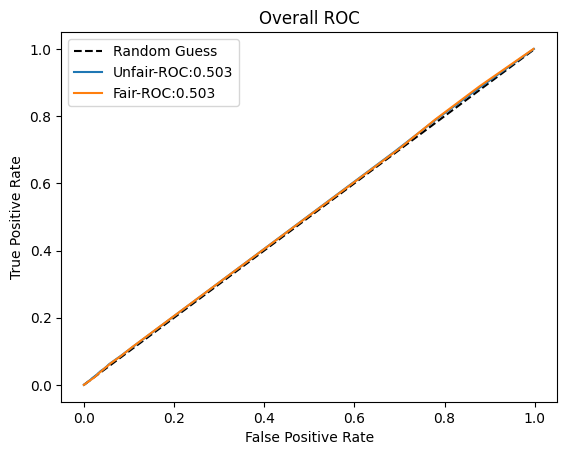

In [471]:
tpr = un_audit_results[0].tp/(un_audit_results[0].tp+un_audit_results[0].fn)
fpr = un_audit_results[0].fp/(un_audit_results[0].fp+un_audit_results[0].tn)
roc = np.trapz(tpr, fpr)
fair_tpr = fair_audit_results[0].tp/(fair_audit_results[0].tp+fair_audit_results[0].fn)
fair_fpr = fair_audit_results[0].fp/(fair_audit_results[0].fp+fair_audit_results[0].tn)
fair_roc = np.trapz(fair_tpr, fair_fpr)
plt.title('Overall ROC')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.plot(fpr, tpr, label=f'Unfair-ROC:{roc:.3f}')
plt.plot(fair_fpr, fair_tpr, label=f'Fair-ROC:{fair_roc:.3f}')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [472]:
# show the results in each group
un_train_signal = un_audit_obj.metric_objects[0].member_signals
un_test_signal = un_audit_obj.metric_objects[0].non_member_signals
un_pop_signal = un_audit_obj.metric_objects[0].reference_signals

fair_train_signal = fair_audit_obj.metric_objects[0].member_signals
fair_test_signal = fair_audit_obj.metric_objects[0].non_member_signals
fair_pop_signal = fair_audit_obj.metric_objects[0].reference_signals

In [473]:
import scipy
def compute_p_value( target_value, observed_distribution):
    return scipy.stats.percentileofscore(observed_distribution, target_value)/100

p_results = {}
p_fair_results = {}

for g in np.unique(g_train):
    un_pop = un_pop_signal[g_pop_train==g]
    p_train = compute_p_value(un_train_signal[g_train==g], un_pop)
    p_test = compute_p_value(un_test_signal[g_test==g], un_pop)
    p_results[g] = {}
    p_results[g]['p'] = np.concatenate([p_train, p_test])
    p_results[g]['mem'] = np.concatenate([np.ones(len(p_train)), np.zeros(len(p_test))])


    fair_pop  = fair_pop_signal[g_pop_train==g]
    p_fair_train = compute_p_value(fair_train_signal[g_train==g], fair_pop)
    p_fair_test = compute_p_value(fair_test_signal[g_test==g], fair_pop)
    p_fair_results[g] = {}
    p_fair_results[g]['p'] = np.concatenate([p_fair_train, p_fair_test])
    p_fair_results[g]['mem'] = np.concatenate([np.ones(len(p_fair_train)), np.zeros(len(p_fair_test))])


In [474]:
g_train.shape

(15244,)

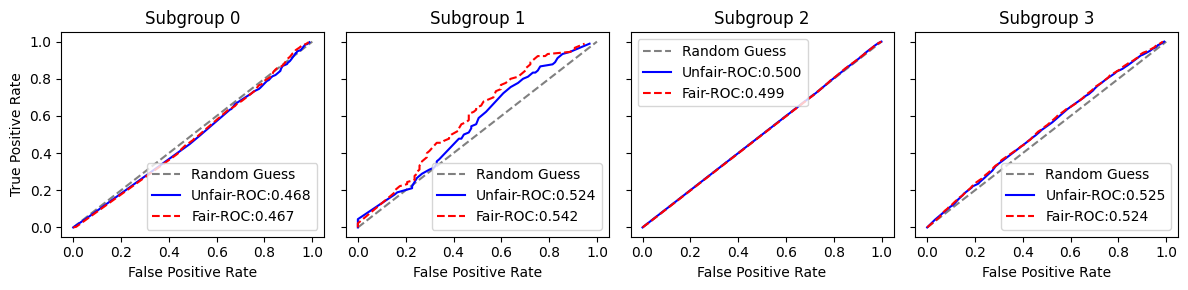

In [475]:
figs, axes = plt.subplots(1,4, figsize=(12,3), sharey=True, sharex=True)

# group = np.unique(g_train)
for idx, group in enumerate(np.unique(g_train)):
    tpr = [np.mean(p_results[group]['p'][p_results[group]['mem']==1]<i) for i in np.linspace(0,1,100)]
    fpr = [np.mean(p_results[group]['p'][p_results[group]['mem']==0]<i) for i in np.linspace(0,1,100)]

    fair_tpr = [np.mean(p_fair_results[group]['p'][p_fair_results[group]['mem']==1]<i) for i in np.linspace(0,1,100)]
    fair_fpr = [np.mean(p_fair_results[group]['p'][p_fair_results[group]['mem']==0]<i) for i in np.linspace(0,1,100)]

    roc = np.trapz(tpr, fpr)
    fair_roc = np.trapz(fair_tpr, fair_fpr)

    axes[idx].plot([0, 1], [0, 1], 'k--', label='Random Guess', color='grey')
    axes[idx].plot(fpr, tpr, label=f'Unfair-ROC:{roc:.3f}', color='blue')
    axes[idx].plot(fair_fpr, fair_tpr, label=f'Fair-ROC:{fair_roc:.3f}', ls='--', color='red')
    axes[idx].set_xlabel('False Positive Rate')
    axes[idx].set_title(f'Subgroup {idx}')
    axes[idx].legend()
axes[0].set_ylabel('True Positive Rate')
plt.tight_layout()

In [476]:
# Initialize dictionaries to store accuracy for each subgroup
accuracy_results = {}
accuracy_fair_results = {}

# Compute accuracy for each subgroup based on the p-values
for group in np.unique(g_train):
    thresholds = np.linspace(0, 1, 100)
    accuracies = []
    fair_accuracies = []

    for i in thresholds:
        # Unfair model accuracy
        tp = np.sum(p_results[group]['p'][p_results[group]['mem'] == 1] < i)
        tn = np.sum(p_results[group]['p'][p_results[group]['mem'] == 0] >= i)
        fp = np.sum(p_results[group]['p'][p_results[group]['mem'] == 0] < i)
        fn = np.sum(p_results[group]['p'][p_results[group]['mem'] == 1] >= i)
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        accuracies.append(accuracy)

        # Fair model accuracy
        fair_tp = np.sum(p_fair_results[group]['p'][p_fair_results[group]['mem'] == 1] < i)
        fair_tn = np.sum(p_fair_results[group]['p'][p_fair_results[group]['mem'] == 0] >= i)
        fair_fp = np.sum(p_fair_results[group]['p'][p_fair_results[group]['mem'] == 0] < i)
        fair_fn = np.sum(p_fair_results[group]['p'][p_fair_results[group]['mem'] == 1] >= i)
        fair_accuracy = (fair_tp + fair_tn) / (fair_tp + fair_tn + fair_fp + fair_fn)
        fair_accuracies.append(fair_accuracy)

    # Store the best accuracy for each subgroup
    accuracy_results[group] = max(accuracies)
    accuracy_fair_results[group] = max(fair_accuracies)

# Print the best accuracy for each subgroup
for group in accuracy_results:
    print(f"Subgroup {group}: Unfair Model Accuracy: {accuracy_results[group]:.3f}, Fair Model Accuracy: {accuracy_fair_results[group]:.3f}")

Subgroup 2.0: Unfair Model Accuracy: 0.520, Fair Model Accuracy: 0.520
Subgroup 3.0: Unfair Model Accuracy: 0.551, Fair Model Accuracy: 0.578
Subgroup 4.0: Unfair Model Accuracy: 0.504, Fair Model Accuracy: 0.504
Subgroup 5.0: Unfair Model Accuracy: 0.525, Fair Model Accuracy: 0.529


In [478]:
# Initialize dictionaries to store accuracy for each subgroup
accuracy_results = {}
accuracy_fair_results = {}

# Compute accuracy for each subgroup based on the p-values
for group in np.unique(g_train):
    thresholds = np.linspace(0, 1, 100)
    accuracies = []
    fair_accuracies = []

    for i in thresholds:
        # Unfair model accuracy
        tp = np.sum(p_results[group]['p'][p_results[group]['mem'] == 1] < i)
        tn = np.sum(p_results[group]['p'][p_results[group]['mem'] == 0] >= i)
        fp = np.sum(p_results[group]['p'][p_results[group]['mem'] == 0] < i)
        fn = np.sum(p_results[group]['p'][p_results[group]['mem'] == 1] >= i)
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        accuracies.append(accuracy)

        # Fair model accuracy
        fair_tp = np.sum(p_fair_results[group]['p'][p_fair_results[group]['mem'] == 1] < i)
        fair_tn = np.sum(p_fair_results[group]['p'][p_fair_results[group]['mem'] == 0] >= i)
        fair_fp = np.sum(p_fair_results[group]['p'][p_fair_results[group]['mem'] == 0] < i)
        fair_fn = np.sum(p_fair_results[group]['p'][p_fair_results[group]['mem'] == 1] >= i)
        fair_accuracy = (fair_tp + fair_tn) / (fair_tp + fair_tn + fair_fp + fair_fn)
        fair_accuracies.append(fair_accuracy)

    # Store the best accuracy for each subgroup
    accuracy_results[group] = max(accuracies)
    accuracy_fair_results[group] = max(fair_accuracies)

# Print the best accuracy for each subgroup
for group in accuracy_results:
    print(f"Subgroup {group}: Unfair Model PR: {accuracy_results[group]:.3f}, Fair Model PR: {accuracy_fair_results[group]:.3f}")

Subgroup 2.0: Unfair Model PR: 0.520, Fair Model PR: 0.520
Subgroup 3.0: Unfair Model PR: 0.551, Fair Model PR: 0.578
Subgroup 4.0: Unfair Model PR: 0.504, Fair Model PR: 0.504
Subgroup 5.0: Unfair Model PR: 0.525, Fair Model PR: 0.529


# Prepare for next run

In [479]:
import os
import shutil

def delete_logs():
    for log_dir in ["fair_log", "un_log"]:
        if os.path.exists(log_dir):
            shutil.rmtree(log_dir)
            print(f"{log_dir} deleted.")

In [480]:
delete_logs()

fair_log deleted.
un_log deleted.
